d:\Capstone\El Nino\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\Capstone\El Nino\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Capstone\El Nino\venv\Lib\site-packages\tcn\tcn.py:227: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)



[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 0
[LightGBM] [Info] Start training from score 0.376311
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

d:\Capstone\El Nino\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Capstone\El Nino\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


d:\Capstone\El Nino\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


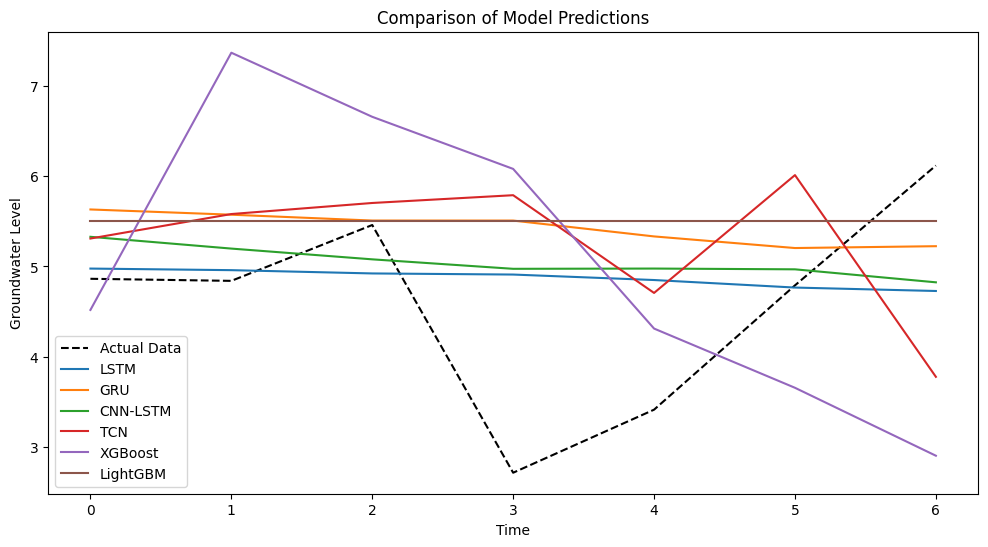

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, Flatten, MaxPooling1D, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tcn import TCN
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset
file_paths = {
    2021: "../dataset/chennai-ground-water-levels-2021.csv",
    2022: "../dataset/chennai-ground-water-levels-2022.csv",
    2023: "../dataset/chennai-ground-water-levels-2023.csv",
    2024: "../dataset/chennai-ground-water-levels-2024.csv"
}

df_list = []
for year, path in file_paths.items():
    df = pd.read_csv(path)
    df["Year"] = year  # Add Year column
    df_list.append(df)

df_all_years = pd.concat(df_list)

df_all_years.rename(columns=lambda x: x.strip(), inplace=True)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df_all_years[months] = df_all_years[months].apply(pd.to_numeric, errors='coerce')

location = "Perambur (East)"
df_location = df_all_years[df_all_years["Location"] == location][["Year"] + months]

df_location = df_location.set_index("Year").stack().reset_index()
df_location.columns = ["Year", "Month", "Groundwater Level"]
df_location["Month"] = df_location["Month"].str.strip()
df_location["Date"] = pd.to_datetime(df_location["Year"].astype(str) + "-" + df_location["Month"], format="%Y-%b", errors="coerce")
df_location = df_location[["Date", "Groundwater Level"]].dropna()
df_location.set_index("Date", inplace=True)

# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_location)

# Prepare sequences for models
sequence_length = 6
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length])
    y.append(data_scaled[i + sequence_length])
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Function to build and train a model
def build_and_train(model, model_name):
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)
    return model

# LSTM Model
lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(64, activation='relu'),
    Dense(1)
])
lstm_model = build_and_train(lstm_model, "LSTM")

# GRU Model
gru_model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    GRU(64, activation='relu'),
    Dense(1)
])
gru_model = build_and_train(gru_model, "GRU")

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dense(1)
])
cnn_lstm_model = build_and_train(cnn_lstm_model, "CNN-LSTM")

# TCN Model
tcn_model = Sequential([
    TCN(input_shape=(sequence_length, 1)),
    Dense(1)
])
tcn_model = build_and_train(tcn_model, "TCN")

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=100)
lgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predictions
models = {"LSTM": lstm_model, "GRU": gru_model, "CNN-LSTM": cnn_lstm_model, "TCN": tcn_model}
predictions = {}

for name, model in models.items():
    predictions[name] = model.predict(X_test).flatten()
predictions["XGBoost"] = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
predictions["LightGBM"] = lgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# Convert predictions back to original scale
for key in predictions:
    predictions[key] = scaler.inverse_transform(predictions[key].reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Data', linestyle='dashed', color='black')
for key, pred in predictions.items():
    plt.plot(pred, label=key)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Groundwater Level")
plt.title("Comparison of Model Predictions")
plt.show()
